In [23]:
from pathlib import Path
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import create_model_from_dict, get_example_model_configs
import yaml
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

print("--- Step 1: Load model and create simulator ---")
model_name = "gauss_gauss_1d_default"
model_config = get_example_model_configs(model_name)


model = create_model_from_dict(model_config)
print(f"Model loaded: {model}")


simulator = ABCSimulator(model=model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- Step 1: Load model and create simulator ---
Model loaded: GaussGaussModel(mu0=0.0, sigma0=5.0, sigma=1.0)
📝 Created temporary observed data for prior sampling mode


In [36]:
print("--- Step 1.5 : Learn Summary Stats (Optional) ---")

import jax
from abcnre.training import get_nn_config
key = jax.random.PRNGKey(123)
key, subkey_learn = jax.random.split(key)


regressor_config = get_nn_config(network_name="deepset",
                          network_size = "default",
                          training_size = "default",
                          task_type = "summary_learner",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)
simulator.learn_summary_stats(subkey_learn, regressor_config)

key, subkey_check = jax.random.split(key)
simulator.check_summary_stats_correlation(
    subkey_check,
    n_samples=10000)

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: summary_learner_deepset_default_default (task: summary_learner)
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: summary_learner
INFO:abcnre.training.components.metrics:   Network: DeepSet
INFO:abcnre.training.components.metrics:   Optimizer: adam
INFO:abcnre.training.components.metrics:   Learning rate: 0.0003
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 256
INFO:abcnre.training.components.metrics:   Samples/epoch: 10240
INFO:abcnre.training.components.metrics:   Max epochs: 100
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.setup:Setting up summary_learner training
INFO:abcnre.training.components.setup:E

--- Step 1.5 : Learn Summary Stats (Optional) ---


INFO:abcnre.training.components.metrics:Epoch   1/100 | Loss: train = 21.062094 val = 18.043736 | LR: 3.00e-04 | Samples: 11,274 | Time: 0.9s
INFO:abcnre.training.train:ETA: 1.3 minutes
INFO:abcnre.training.components.metrics:Epoch  11/100 | Loss: train = 8.897247 val = 9.176363 | LR: 3.00e-04 | Samples: 113,674 | Time: 2.3s
INFO:abcnre.training.components.metrics:Epoch  21/100 | Loss: train = 5.096270 val = 5.626554 | LR: 3.00e-04 | Samples: 216,074 | Time: 3.7s
INFO:abcnre.training.components.metrics:Epoch  31/100 | Loss: train = 3.171854 val = 3.252938 | LR: 3.00e-04 | Samples: 318,474 | Time: 5.1s
INFO:abcnre.training.components.metrics:Epoch  41/100 | Loss: train = 1.930785 val = 1.890497 | LR: 3.00e-04 | Samples: 420,874 | Time: 6.6s
INFO:abcnre.training.components.metrics:Epoch  51/100 | Loss: train = 1.099403 val = 1.170033 | LR: 3.00e-04 | Samples: 523,274 | Time: 7.9s
INFO:abcnre.training.components.metrics:Epoch  61/100 | Loss: train = 0.727566 val = 0.781704 | LR: 3.00e-04 

✅ Updating model's summary statistics function...
✅ Summary statistics learned and updated successfully!
   - Original data dimension: (10,)
   - Learned summary function integrated into model
Shapes : phi_samples: (10000, 1) x_samples: (10000, 10, 1)
Shapes: summary_stats: (10000, 1) phi_samples: (10000, 1)
Correlation between summary statistics and model parameters: [[0.9949483]]


Array([[0.9949483]], dtype=float32)

VERIFY THE CORRELATION (CAN BE COMPUTED)
TEST DRIVEN DEV from now on (SIMPLE TASK) SIMPLER TASK (CLASSIF REGRESSOR)
SUMMARY LEARNER -> REGRESSOR
FRIDAY RYAN TEST (MAKE HIS LIFE EASY AS POSSIBLE) --> 100D GAUSS TEST

In [25]:
#

key, key_sim = jax.random.split(key)


In [26]:
print("--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---")

true_theta = 2.5
key, subkey_sample = jax.random.split(key)
x_obs = simulator.model.simulate_data(subkey_sample, true_theta)

simulator.update_observed_data(x_obs)
print(f"Observation x_obs: {x_obs}")

quantile_distance = 1.
key, subkey_epsilon = jax.random.split(key)
simulator.set_epsilon_from_quantile(key = subkey_epsilon, quantile_distance=quantile_distance, n_samples=10000)

--- Step 2.1: Sample x_obs and initialize the ABCSimulator ---
🔄 Updated sampler with new observed data.
Observation x_obs: [[4.6136894]
 [3.7419693]
 [2.7883747]
 [2.0384965]
 [2.2912316]
 [3.0152106]
 [3.3933015]
 [3.4819908]
 [1.1553577]
 [1.5837486]]
🔄 Updated sampler with new observed data.
Observation x_obs: [[4.6136894]
 [3.7419693]
 [2.7883747]
 [2.0384965]
 [2.2912316]
 [3.0152106]
 [3.3933015]
 [3.4819908]
 [1.1553577]
 [1.5837486]]


In [27]:
print("--- Step 2.2: Save model to YAML (Optional) ---")

from abcnre.simulation import save_simulator_to_yaml


save_simulator_to_yaml(
    simulator,
    results_dir / "simulator" / "simulator.yaml",
    overwrite=True
)

INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Saved summary network weights to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_weights.npz
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/e

--- Step 2.2: Save model to YAML (Optional) ---


INFO:abcnre.simulation.io:Loaded model: GaussGaussModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded summary network config from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/simulator/simulator_summary_network_config.yml
INFO:abcnre.simulation.io:

--- Step 2.3 : Load model from YAML and check (Optional) ---
Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


INFO:abcnre.simulation.io:Summary network loaded and integrated into simulator


Text(0.5, 0, 'Phi samples')

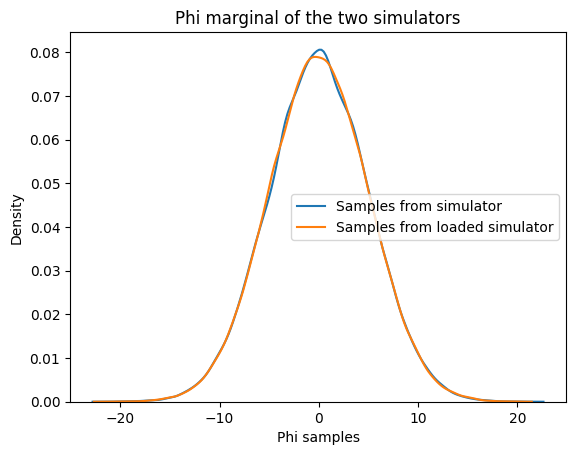

In [28]:
print("--- Step 2.3 : Load model from YAML and check (Optional) ---")

from abcnre.simulation import load_simulator_from_yaml
simulator_loaded = load_simulator_from_yaml(
    results_dir / "simulator" / "simulator.yaml",
)

key, key_samples, key_samples_load = jax.random.split(key, 3)
samples = simulator_loaded.generate_samples(key_samples, n_samples=100000)
samples_load = simulator_loaded.generate_samples(key_samples_load, n_samples=100000)

import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples.phi.flatten(), label="Samples from simulator"
            )
sns.kdeplot(samples_load.phi.flatten(), label="Samples from loaded simulator")
plt.legend()
plt.title("Phi marginal of the two simulators")
plt.xlabel("Phi samples")

In [29]:
from abcnre.training import NNConfig, NetworkConfig, TrainingConfig, get_nn_config
print("--- Step 3.1: Create NNConfig for training ---")
nn_config = get_nn_config(network_name="mlp",
                          network_size = "default",
                          training_size = "default",
                          task_type = "classifier",
                          lr_scheduler_name = "reduce_on_plateau",
                          lr_scheduler_variant = "default",
                          stopping_rules_variant = "balanced",
                          experiment_name = None)


nn_config.training.num_epochs = 500
nn_config.training.batch_size = 1024
nn_config.training.n_samples_per_epoch = 10240
nn_config.training.learning_rate = 1e-2
nn_config.training.optimizer= "adamw"
nn_config.training.weight_decay = 1e-3

INFO:abcnre.training.config:Using custom lr_scheduler: reduce_on_plateau_default
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Using stopping rules: balanced
INFO:abcnre.training.config:Created NN config: classifier_mlp_default_default (task: classifier)
INFO:abcnre.training.config:Created NN config: classifier_mlp_default_default (task: classifier)


--- Step 3.1: Create NNConfig for training ---


In [30]:
print("--- Step 3.2: Create NeuralRatioEstimator ---")

from abcnre.inference import NeuralRatioEstimator    

estimator = NeuralRatioEstimator(
    nn_config=nn_config,
    simulator=simulator)

--- Step 3.2: Create NeuralRatioEstimator ---


In [31]:
print("--- Step 3.3: Train the NeuralRatioEstimator ---")

key, key_train = jax.random.split(key)
res = estimator.train(key_train, n_phi_to_store = 10000)

INFO:abcnre.inference.estimator:Using MLP without summary statistics
INFO:abcnre.inference.estimator:Storing 10000 phi during training
INFO:abcnre.training.components.metrics:Configuration Summary:
INFO:abcnre.training.components.metrics:   Task: classifier
INFO:abcnre.training.components.metrics:   Network: MLP
INFO:abcnre.training.components.metrics:   Optimizer: adamw
INFO:abcnre.training.components.metrics:   Learning rate: 0.01
INFO:abcnre.training.components.metrics:   LR scheduler: reduce_on_plateau
INFO:abcnre.training.components.metrics:   Batch size: 1024
INFO:abcnre.training.components.metrics:   Samples/epoch: 10240
INFO:abcnre.training.components.metrics:   Max epochs: 500
INFO:abcnre.training.components.metrics:   Stopping rules: Enabled
INFO:abcnre.training.components.metrics:   Phi storage: 10000 values
INFO:abcnre.training.components.setup:Setting up classifier training
INFO:abcnre.training.components.setup:Epochs: 500, Batch size: 1024, Batches/epoch: 10
INFO:abcnre.i

--- Step 3.3: Train the NeuralRatioEstimator ---


INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for MLP network
INFO:abcnre.training.registry:Created MLP network (from 'MLP') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': False, 'dropout_rate': 0.0, 'hidden_dims': [64, 64, 64], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: MLP
INFO:abcnre.training.registry:Set output_dim=1 for MLP network
INFO:abcnre.training.registry:Created MLP network (from 'MLP') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': False, 'dropout_rate': 0.0, 'hidden_dims': [64, 64, 64], 'output_dim': 1}
INFO:abcnre.training.components.setup:Created network: MLP
INFO:abcnre.training.components.setup:Network initialized with 9,153 parameters
INFO:abcnre.training.components.setup:Using same generator for validation data
INFO:abcnre.training.components.setup:N

✅ Neural Ratio Estimator training completed successfully!
   - Final train loss: 0.1627260446548462
   - Total simulations: 205317


In [34]:
print("--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---")

from abcnre.inference.io import save_estimator_to_yaml
save_estimator_to_yaml(
    estimator,
    results_dir / "estimator" / "estimator.yaml",
    overwrite=True
)


INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.inference.io:Saved classifier config to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.models.io:Model saved to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved model configuration to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_model.yml
INFO:abcnre.simulation.io:Saved observed data to: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Configuration saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnr

--- Step 3.4: Save the NeuralRatioEstimator to YAML (Optional) ---
True stored_phis attribute not found in estimator


INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_classif_config.yaml
INFO:abcnre.simulation.io:Loaded model: GaussGaussModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_summary_network_config.yml
INFO:abcnre.simulation.io:Loaded model: GaussGaussModel
INFO:abcnre.simulation.io:Loaded observed data from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/estimator/estimator_simulator_observed_data.npy
INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/es

--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---
Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


Text(0.5, 1.0, 'Phi marginal of the two estimators')

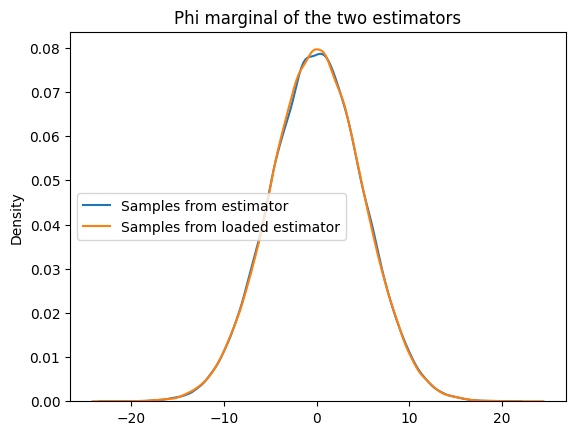

In [35]:
print("--- Step 3.5: Load the NeuralRatioEstimator from YAML and check (Optional) ---")

from abcnre.inference import load_estimator_from_yaml

estimator_loaded = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

key, key_samples_estimator, key_samples_estimator_load = jax.random.split(key, 3)
samples_estimator = estimator.simulator.generate_samples(key_samples_estimator, n_samples=100000)
samples_estimator_load = estimator_loaded.simulator.generate_samples(key_samples_estimator_load, n_samples=100000)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(samples_estimator.phi.flatten(), label="Samples from estimator")
sns.kdeplot(samples_estimator_load.phi.flatten(), label="Samples from loaded estimator")
plt.legend()
plt.title("Phi marginal of the two estimators") 